In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip uninstall scikit-learn-intelex -y

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

!pip install "protobuf<=3.20.3" --force-reinstall

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as stats # Statistical functions (Skewness, Kurtosis, Box-Cox)

# ------------------------------------------------------------------------------
# 2. VISUALIZATION LIBRARIES
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt  # Basic Plotting
import seaborn as sns            # Statistical Data Visualization
import plotly.express as px      # Interactive Visualization
from matplotlib import rcParams  # Figure size and parameter configuration

# ------------------------------------------------------------------------------
# 3. PREPROCESSING & FEATURE ENGINEERING (Scikit-Learn)
# ------------------------------------------------------------------------------
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,  # Scaling
    LabelEncoder, OneHotEncoder,                 # Encoding
    PolynomialFeatures, PowerTransformer         # Transformations
)
from sklearn.impute import SimpleImputer, KNNImputer # Missing Value Handling
from sklearn.decomposition import LatentDirichletAllocation as LDA, PCA          # Dimensionality Reduction
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold,    # Splitting
    cross_val_score, GridSearchCV, RandomizedSearchCV # Validation & Tuning
)
from imblearn.over_sampling import SMOTE         # Handling Imbalance (if needed)

# ------------------------------------------------------------------------------
# 4. MACHINE LEARNING MODELS
# ------------------------------------------------------------------------------
# Linear Models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, 
    LogisticRegression, SGDRegressor
)
# Support Vector Machines
from sklearn.svm import SVR, SVC, LinearSVC
# Neighbors
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
# Tree Based & Ensemble
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, 
    AdaBoostRegressor, ExtraTreesRegressor
)
from sklearn.naive_bayes import GaussianNB

# ------------------------------------------------------------------------------
# 5. ADVANCED BOOSTING LIBRARIES
# ------------------------------------------------------------------------------
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# ------------------------------------------------------------------------------
# 6. DEEP LEARNING (TensorFlow & Keras)
# ------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# ------------------------------------------------------------------------------
# 7. METRICS & UTILITIES
# ------------------------------------------------------------------------------
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, classification_report, roc_auc_score
)
import warnings

# Configuration
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output
pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.max_rows', 100)     # Display more rows
plt.style.use('ggplot')                    # Visualization style

print("Libraries Imported Successfully!")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found existing installation: scikit-learn-intelex 2025.9.0
Uninstalling scikit-learn-intelex-2025.9.0:
  Successfully uninstalled scikit-learn-intelex-2025.9.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=

2025-12-15 14:02:13.915797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765807334.136816      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765807334.197734      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries Imported Successfully!
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Load Datasets
# Assuming the files are in a folder named 'data'
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# Combine Train and Test for Consistent Preprocessing (Important Step!)
# We separate them later to prevent Data Leakage, but for cleaning and encoding, 
# seeing the whole picture (especially for categorical levels) is sometimes useful 
# provided we are careful not to use target statistics from test.
all_data = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"All Data Shape: {all_data.shape}")

# Initial Look
train_df.head()

Train Shape: (1460, 81)
Test Shape: (1459, 80)
All Data Shape: (2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


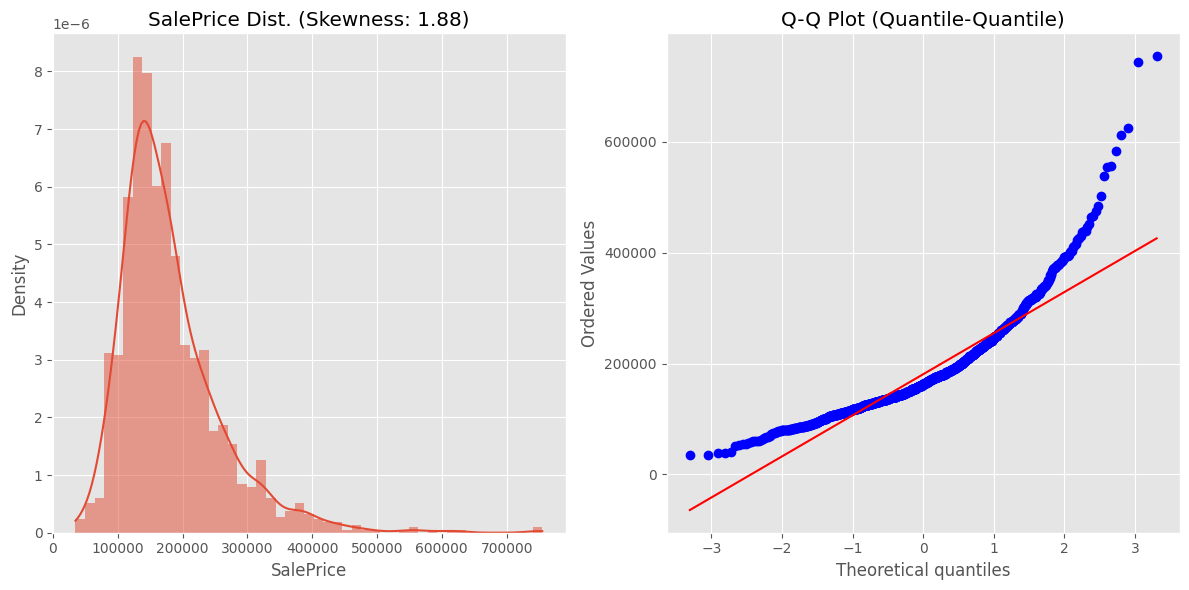

Skewness: 1.8829
Kurtosis: 6.5363


In [3]:
# ------------------------------------------------------------------------------
# 1. TARGET VARIABLE ANALYSIS
# ------------------------------------------------------------------------------

# Analyze the distribution of SalePrice
(mu, sigma) = stats.norm.fit(train_df['SalePrice'])

plt.figure(figsize=(12, 6))

# Histogram and Normal Probability Plot
plt.subplot(1, 2, 1)
sns.histplot(train_df['SalePrice'], kde=True, stat="density", linewidth=0)
plt.title(f'SalePrice Dist. (Skewness: {train_df["SalePrice"].skew():.2f})')
plt.xlabel('SalePrice')

plt.subplot(1, 2, 2)
stats.probplot(train_df['SalePrice'], plot=plt)
plt.title('Q-Q Plot (Quantile-Quantile)')

plt.tight_layout()
plt.show()

print(f"Skewness: {train_df['SalePrice'].skew():.4f}")
print(f"Kurtosis: {train_df['SalePrice'].kurt():.4f}")

In [4]:
# Apply Log Transformation to Target
# We use np.log1p which calculates log(1 + x) to ensure mathematical stability
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

print(f"New Skewness after Log Transform: {train_df['SalePrice'].skew():.4f}")

# Visualization after transformation ensures we are closer to Normal Distribution

New Skewness after Log Transform: 0.1213


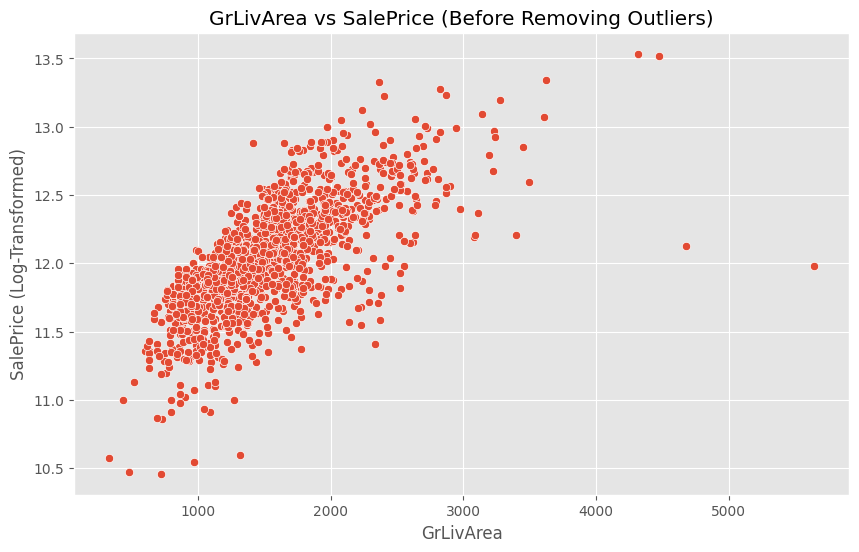

Dropping 2 outliers at indices: [ 523 1298]


In [5]:
# ------------------------------------------------------------------------------
# 2. OUTLIER DETECTION
# ------------------------------------------------------------------------------

# Visualizing the relationship between GrLivArea and SalePrice
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.title('GrLivArea vs SalePrice (Before Removing Outliers)')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice (Log-Transformed)')
plt.show()

# Based on the plot and documentation:
# There are outliers with GrLivArea > 4000 but low SalePrice.
# These points will confuse the model significantly.

# Removing Outliers
outliers_index = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 12.5)].index
print(f"Dropping {len(outliers_index)} outliers at indices: {outliers_index.values}")

train_df = train_df.drop(outliers_index)
train_df.reset_index(drop=True, inplace=True)

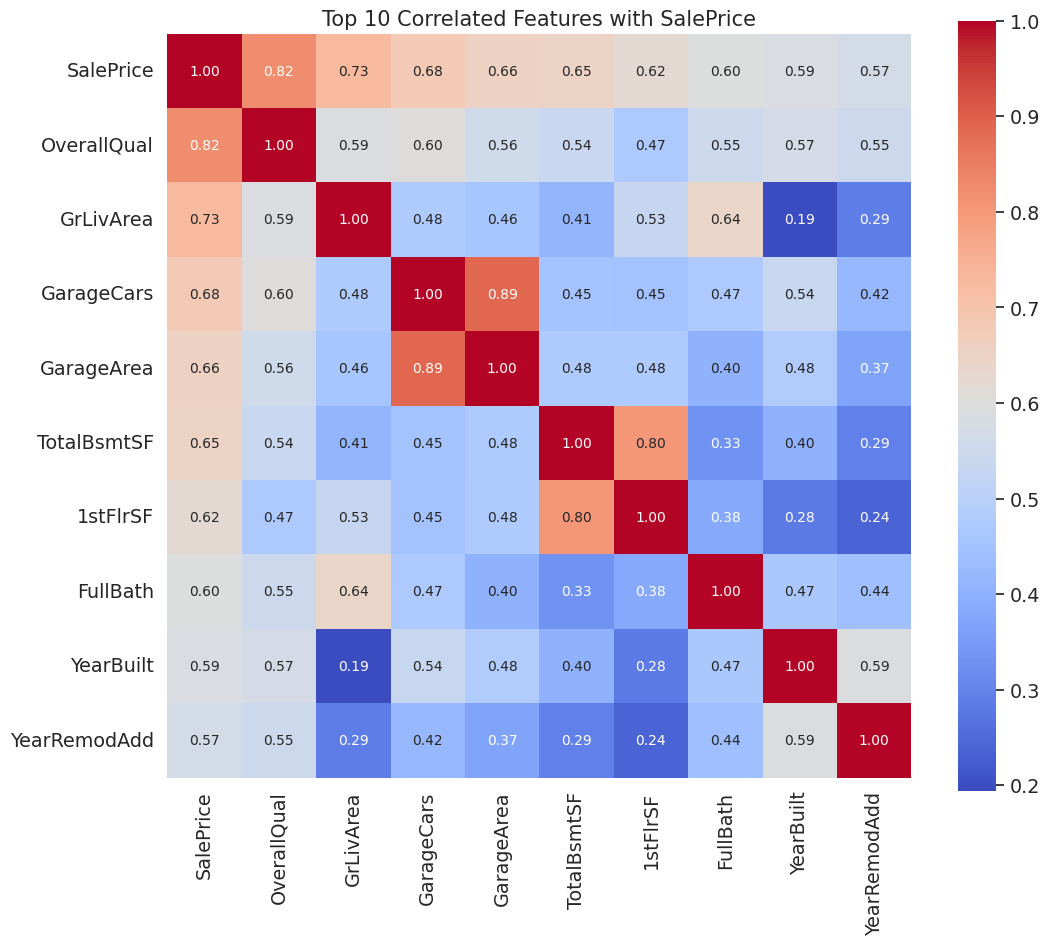

In [6]:
# ------------------------------------------------------------------------------
# 3. CORRELATION MATRIX
# ------------------------------------------------------------------------------

# Calculate correlation matrix
corr_matrix = train_df.corr(numeric_only=True)

# Filter to show only the most correlated features with SalePrice
k = 10 # Number of variables for heatmap
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(train_df[cols].values.T)

plt.figure(figsize=(12, 10))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
            yticklabels=cols.values, xticklabels=cols.values, cmap='coolwarm')
plt.title('Top 10 Correlated Features with SalePrice')
plt.show()

              Missing Ratio %
PoolQC              99.691464
MiscFeature         96.400411
Alley               93.212204
Fence               80.425094
MasVnrType          60.541652
FireplaceQu         48.680151
LotFrontage         16.660953
GarageFinish         5.450806
GarageQual           5.450806
GarageCond           5.450806
GarageYrBlt          5.450806
GarageType           5.382242
BsmtExposure         2.811107
BsmtCond             2.811107
BsmtQual             2.776826
BsmtFinType2         2.742544
BsmtFinType1         2.708262
MasVnrArea           0.788481
MSZoning             0.137127
BsmtFullBath         0.068564


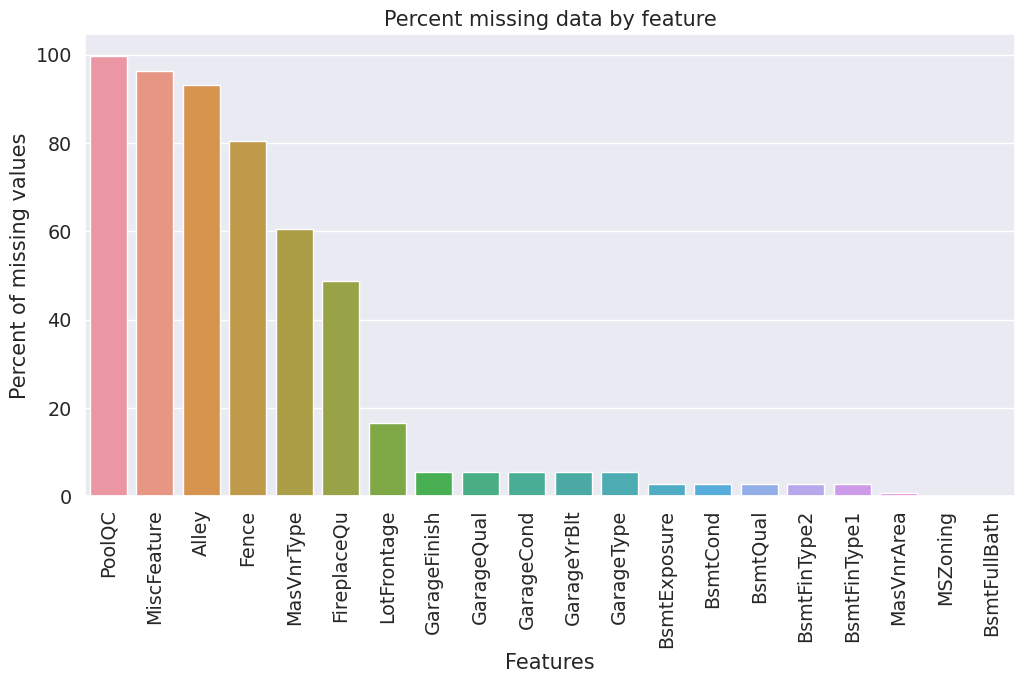

In [7]:
# ------------------------------------------------------------------------------
# 4. MISSING VALUE ANALYSIS
# ------------------------------------------------------------------------------

# Re-combine train and test (since we dropped outliers from train)
n_train = train_df.shape[0]
n_test = test_df.shape[0]
y_train = train_df.SalePrice.values # Save target variable
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

# Calculate missing percentage
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)

missing_data = pd.DataFrame({'Missing Ratio %': all_data_na})
print(missing_data.head(20))

# Visualize Missing Data
plt.figure(figsize=(12, 6))
sns.barplot(x=all_data_na.index[:20], y=all_data_na[:20])
plt.xticks(rotation='vertical')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

In [8]:
# ------------------------------------------------------------------------------
# 5. DATA IMPUTATION
# ------------------------------------------------------------------------------

# A. Group-based Imputation for LotFrontage
# We group by 'Neighborhood' and fill missing LotFrontage with the median of that neighborhood.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# B. Meaningful Missing Values (NaN implies 'None' or 'No Feature')
# Based on data description, NA in these columns means the house lacks that feature.
cols_fill_none = [
    "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "MasVnrType"
]
for col in cols_fill_none:
    all_data[col] = all_data[col].fillna("None")

# C. Numerical Missing Values (NaN implies 0)
# If there is no garage, the garage area is 0.
cols_fill_zero = [
    "GarageYrBlt", "GarageArea", "GarageCars",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
    "BsmtFullBath", "BsmtHalfBath", "MasVnrArea"
]
for col in cols_fill_zero:
    all_data[col] = all_data[col].fillna(0)

# D. Mode Imputation (Most Frequent)
# For these categorical variables, missing values are rare. We fill with the most common value.
cols_fill_mode = ["MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType"]
for col in cols_fill_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# E. Special Case: Functional
# Data description says "Assume typical unless deductions are warranted"
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# F. Drop Useless Columns
# Utilities has extremely low variance (almost all are "AllPub"), so it doesn't help the model.
all_data = all_data.drop(['Utilities'], axis=1)

# Verification
print(f"Total Missing Values Left: {all_data.isnull().sum().sum()}")

Total Missing Values Left: 0


In [9]:
# ------------------------------------------------------------------------------
# 6. FEATURE ENGINEERING
# ------------------------------------------------------------------------------

# 1. Transforming Numerical Variables to Categorical
# MSSubClass: The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
# OverallCond: Sketchy variable, convert to categorical so we can label encode it later
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
# YrSold and MoSold: Year and Month sold are discrete categories
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# 2. Creating New Features
# Total Square Footage: Combining basement, 1st and 2nd floor areas
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 3. Label Encoding for Ordinal Variables
# Some categorical variables have an inherent order (Poor < Fair < Typical < Good < Excellent).
# LabelEncoder preserves this order roughly.
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

print("Processing Label Encoding...")
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

print(f"Shape after Feature Engineering: {all_data.shape}")

Processing Label Encoding...
Shape after Feature Engineering: (2917, 80)


In [10]:
# ------------------------------------------------------------------------------
# 7. SKEWNESS HANDLING (BOX-COX TRANSFORM)
# ------------------------------------------------------------------------------
from scipy.stats import skew
from scipy.special import boxcox1p

# Check skewness of all numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(10))

# Filter features with skewness > 0.75
skewness = skewness[abs(skewness) > 0.75]
print(f"There are {skewness.shape[0]} skewed numerical features to Box Cox transform")

# Apply Box-Cox Transformation
skewed_features = skewness.index
lam = 0.15 # Lambda value for Box-Cox
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
print("Skewness fixed.")

                    Skew
MiscVal        21.939672
PoolArea       17.688664
LotArea        13.109495
LowQualFinSF   12.084539
3SsnPorch      11.372080
LandSlope       4.973254
KitchenAbvGr    4.300550
BsmtFinSF2      4.144503
EnclosedPorch   4.002344
ScreenPorch     3.945101
There are 60 skewed numerical features to Box Cox transform
Skewness fixed.


In [11]:
# ------------------------------------------------------------------------------
# 8. GET DUMMIES & SPLIT DATA
# ------------------------------------------------------------------------------

# Create dummy variables for categorical features
all_data = pd.get_dummies(all_data)
print(f"Shape after One-Hot Encoding: {all_data.shape}")

# Split back into Train and Test sets
train = all_data[:n_train]
test = all_data[n_train:]

print(f"Final Train Shape: {train.shape}")
print(f"Final Test Shape: {test.shape}")

# Save processed data (Optional but good practice)
# train.to_csv('data/processed_train.csv', index=False)
# test.to_csv('data/processed_test.csv', index=False)

Shape after One-Hot Encoding: (2917, 221)
Final Train Shape: (1458, 221)
Final Test Shape: (1459, 221)


In [12]:
# ------------------------------------------------------------------------------
# 9. MODELING SETUP
# ------------------------------------------------------------------------------
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Validation Function (K-Fold)
# n_folds = 5 means we split data into 5 parts. Train on 4, test on 1. Repeat 5 times.
n_folds = 5

def rmsle_cv(model):
    """
    Calculates Root Mean Squared Logarithmic Error using Cross-Validation.
    Since we already log-transformed the target variable, we can use 
    'neg_mean_squared_error' and take the square root.
    """
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

print("Cross-Validation function defined.")

Cross-Validation function defined.


In [13]:
# ------------------------------------------------------------------------------
# 10. BASE MODELS INSTANTIATION
# ------------------------------------------------------------------------------
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

# A. LASSO Regression
# We use RobustScaler() before the model to handle remaining outliers efficiently.
# alpha: Regularization strength. Higher value = more regularization (simpler model).
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

# B. ElasticNet Regression
# l1_ratio: Mixing parameter. 0 for Ridge, 1 for Lasso. 0.9 is closer to Lasso.
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# C. Kernel Ridge Regression
# kernel='polynomial': Allows learning non-linear patterns.
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

print("Linear Base Models Initialized.")

Linear Base Models Initialized.


In [14]:
# ------------------------------------------------------------------------------
# 11. BOOSTING MODELS INSTANTIATION
# ------------------------------------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# A. Gradient Boosting Regressor
# loss='huber': Robust to outliers.
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

# B. XGBoost Regressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread=-1)

# C. LightGBM Regressor
# leaf_prediction means calculating the value of a leaf directly, usually faster.
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

print("Boosting Models Initialized.")

Boosting Models Initialized.


In [15]:
# ------------------------------------------------------------------------------
# 12. MODEL EVALUATION LOOP
# ------------------------------------------------------------------------------

print("Starting Cross-Validation... This may take a minute.")

score = rmsle_cv(lasso)
print(f"\nLasso score: {score.mean():.4f} ({score.std():.4f})")

score = rmsle_cv(ENet)
print(f"ElasticNet score: {score.mean():.4f} ({score.std():.4f})")

score = rmsle_cv(KRR)
print(f"Kernel Ridge score: {score.mean():.4f} ({score.std():.4f})")

score = rmsle_cv(GBoost)
print(f"Gradient Boosting score: {score.mean():.4f} ({score.std():.4f})")

score = rmsle_cv(model_xgb)
print(f"XGBoost score: {score.mean():.4f} ({score.std():.4f})")

score = rmsle_cv(model_lgb)
print(f"LightGBM score: {score.mean():.4f} ({score.std():.4f})")

Starting Cross-Validation... This may take a minute.

Lasso score: 0.1115 (0.0074)
ElasticNet score: 0.1116 (0.0074)
Kernel Ridge score: 0.1163 (0.0065)
Gradient Boosting score: 0.1161 (0.0078)
XGBoost score: 0.1167 (0.0082)
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min

In [16]:
# ------------------------------------------------------------------------------
# 13. STACKING ENSEMBLE CLASS
# ------------------------------------------------------------------------------
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # Fit the models on the data
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train base models and create "out-of-fold" predictions to train the meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Train the meta-model using the out-of-fold predictions as new features
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Prediction logic
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_
        ])
        return self.meta_model_.predict(meta_features)

print("Stacking Class defined successfully.")

Stacking Class defined successfully.


In [17]:
# Initialize Stacking Model
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=lasso
)

# Evaluate Performance
score = rmsle_cv(stacked_averaged_models)
print(f"Stacking Averaged models score: {score.mean():.4f} ({score.std():.4f})")

Stacking Averaged models score: 0.1079 (0.0072)


In [18]:
# ------------------------------------------------------------------------------
# 14. FINAL TRAINING AND PREDICTION
# ------------------------------------------------------------------------------

# Define RMSLE function for final check on training data
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# 1. Train Stacked Model
print("Training Stacked Model on full data...")
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values)) # Reverse Log Transform
print(f"Stacked Model RMSE on Train: {rmsle(y_train, stacked_train_pred):.4f}")

# 2. Train XGBoost
print("Training XGBoost...")
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(f"XGBoost RMSE on Train: {rmsle(y_train, xgb_train_pred):.4f}")

# 3. Train LightGBM
print("Training LightGBM...")
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(f"LightGBM RMSE on Train: {rmsle(y_train, lgb_train_pred):.4f}")

# ------------------------------------------------------------------------------
# 15. ENSEMBLE PREDICTION (WEIGHTED AVERAGE)
# ------------------------------------------------------------------------------

print("Blending models...")
# Weighted average of the three models
ensemble = stacked_pred * 0.70 + xgb_pred * 0.15 + lgb_pred * 0.15

print("Ensemble prediction complete.")

Training Stacked Model on full data...
Stacked Model RMSE on Train: 0.0789
Training XGBoost...
XGBoost RMSE on Train: 0.0866
Training LightGBM...
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] mi

In [19]:
# ------------------------------------------------------------------------------
# 16. SUBMISSION
# ------------------------------------------------------------------------------

sub = pd.DataFrame()
sub['Id'] = test_df['Id'] # Original Test IDs
sub['SalePrice'] = ensemble
sub.to_csv('submission_house_prices_v1.csv', index=False)

print("Submission file saved successfully as 'submission_house_prices_v1.csv'")

Submission file saved successfully as 'submission_house_prices_v1.csv'


In [20]:
# ------------------------------------------------------------------------------
# 17. DEEP LEARNING PREPROCESSING
# ------------------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

# Neural Networks require scaled data for Gradient Descent to converge efficiently.
scaler = StandardScaler()

# Fit on training data ONLY to avoid data leakage
X_train_scaled = scaler.fit_transform(train.values)
X_test_scaled = scaler.transform(test.values)
y_train_dl = y_train # Target variable (log transformed prices)

print("Data Scaled for Neural Network.")
print(f"Input Shape: {X_train_scaled.shape}")

Data Scaled for Neural Network.
Input Shape: (1458, 221)


In [21]:
# ------------------------------------------------------------------------------
# 18. NEURAL NETWORK ARCHITECTURE
# ------------------------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_model(input_dim):
    model = Sequential([
        # Layer 1
        Dense(256, input_dim=input_dim, kernel_initializer='normal', activation='relu'),
        BatchNormalization(),
        Dropout(0.3), # Drop 30% of neurons to prevent overfitting
        
        # Layer 2
        Dense(128, kernel_initializer='normal', activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Layer 3
        Dense(64, kernel_initializer='normal', activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output Layer (1 neuron for regression)
        Dense(1, kernel_initializer='normal', activation='linear')
    ])
    
    # Compile Model
    # We monitor Mean Absolute Error (MAE) as an additional metric
    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(learning_rate=0.001), 
                  metrics=['mae'])
    return model

print("Neural Network Architecture Defined.")

Neural Network Architecture Defined.


In [22]:
# ------------------------------------------------------------------------------
# 19. TRAINING THE NEURAL NETWORK
# ------------------------------------------------------------------------------

# Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Split for validation (Since Keras needs a validation set to monitor overfitting)
# We use a simple split here, but K-Fold is also possible.
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train_dl, test_size=0.2, random_state=42)

# Build Model
model_nn = build_model(X_train_scaled.shape[1])

# Train Model
print("Starting Neural Network Training...")
history = model_nn.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=150,           # Maximum epochs
    batch_size=32,        # Update weights every 32 samples
    callbacks=[early_stop, reduce_lr],
    verbose=0             # 0 to keep the output clean, 1 for progress bar
)

print(f"Training Completed. Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Make Predictions
nn_pred_log = model_nn.predict(X_test_scaled)
nn_pred = np.expm1(nn_pred_log).flatten() # Reverse Log Transform and flatten array

Starting Neural Network Training...


2025-12-15 14:09:01.813887: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Training Completed. Final Validation Loss: 0.0782
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


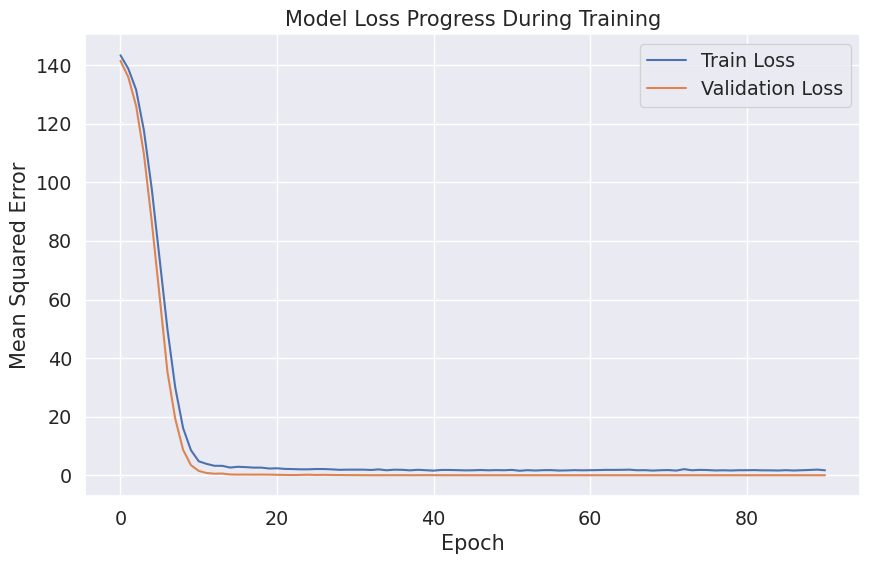

In [23]:
# Visualize Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress During Training')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
# ------------------------------------------------------------------------------
# 20. ULTIMATE ENSEMBLE BLENDING
# ------------------------------------------------------------------------------

# New weights considering Neural Network
# Stacked model usually gets the highest weight as it's already an ensemble.
final_ensemble = (stacked_pred * 0.60) + \
                 (xgb_pred * 0.15) + \
                 (lgb_pred * 0.15) + \
                 (nn_pred * 0.10)

# Save Final Submission
sub_nn = pd.DataFrame()
sub_nn['Id'] = test_df['Id']
sub_nn['SalePrice'] = final_ensemble
sub_nn.to_csv('submission_ultimate_blend.csv', index=False)

print("Ultimate submission file saved! Ready for Kaggle.")

Ultimate submission file saved! Ready for Kaggle.
